# Language modeling with simple MLP

- Manual backprop
- Pytorchifying the model 
- Improve training loop

Sources: 
- https://github.com/karpathy/nn-zero-to-hero
- https://github.com/karpathy/makemore
- https://huggingface.co/course/chapter6/6?fw=pt

Resources:
- https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue_no_trainer.py
- https://huggingface.co/course/chapter1/1

In [170]:
import torch
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
from collections import defaultdict
%matplotlib inline

In [171]:
# download the names.txt file from github
!wget -O input.txt https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
# !wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2023-05-19 14:18:27--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>] 222.80K  --.-KB/s    in 0.02s   

2023-05-19 14:18:27 (10.1 MB/s) - ‘input.txt’ saved [228145/228145]



In [172]:
# Set seeds
torch.manual_seed(42)
random.seed(42)

In [173]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [174]:
len(words)

32033

### Manual backprop

In [175]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [176]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [177]:
# Init HP
vocab_size = len(itos)
emb_dim = 2
block_size = 3
h_dim = 100
lr=0.1
max_steps=100000

In [ ]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [178]:
# Get random batch
g = torch.Generator().manual_seed(42) # for reproducibility
C = torch.randn((vocab_size, emb_dim), generator=g)
W1 = torch.randn((emb_dim * block_size, h_dim), generator=g)
b1 = torch.randn(h_dim, generator=g)
W2 = torch.randn((h_dim, vocab_size), generator=g)
b2 = torch.randn(vocab_size , generator=g)
batch_size= 32
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

In [179]:
# Chunkated forward pass
emb = C[Xb]
embcat = emb.view(-1, 6)
hpreact = embcat @ W1 + b1
h = torch.tanh(hpreact)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yb)

# PyTorch backward pass
for p in parameters:
    p.grad = None
for t in [logits, h, hpreact, embcat, emb]:
    t.retain_grad()
loss.backward()
loss

tensor(15.9575, grad_fn=<NllLossBackward0>)

In [192]:
emb.shape

torch.Size([32, 3, 2])

In [193]:
emb[0]

tensor([[-0.3925, -1.4036],
        [ 1.2791,  1.2964],
        [ 1.2791,  1.2964]], grad_fn=<SelectBackward0>)

In [190]:
embcat.shape

torch.Size([32, 6])

In [194]:
Xb[0]

tensor([ 5, 12, 12])

In [196]:
# Derivative of loss for single observation
# TODO:
# Loss
davg_logits = F.softmax(logits, 1)
davg_logits[range(batch_size), Yb] -= 1
dlogits = 1/batch_size * davg_logits
# Layer 2
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)

# Tanh
dhpreact = (1 - torch.tanh(hpreact)**2) * dh

# Layer 1
dembcat = dhpreact @ W1.T 
dW1 = embcat.T @ dhpreact
db1 = dhpreact.sum(0)

# Concatenation
demb = dembcat.view(emb.shape)

# Embedding
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]


cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logits          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10
h               | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09
W2              | exact: False | approximate: True  | maxdiff: 1.4901161193847656e-08
b2              | exact: False | approximate: True  | maxdiff: 1.4901161193847656e-08
hpreact         | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09
embcat          | exact: False | approximate: True  | maxdiff: 4.0978193283081055e-08
W1              | exact: False | approximate: True  | maxdiff: 1.1920928955078125e-07
b1              | exact: False | approximate: True  | maxdiff: 2.9802322387695312e-08
emb             | exact: False | approximate: True  | maxdiff: 4.0978193283081055e-08
C               | exact: False | approximate: True  | maxdiff: 1.6391277313232422e-07


In [203]:
# Model
g = torch.Generator().manual_seed(42) # for reproducibility
C = torch.randn((vocab_size, emb_dim), generator=g)
W1 = torch.randn((emb_dim * block_size, h_dim), generator=g)
b1 = torch.randn(h_dim, generator=g)
W2 = torch.randn((h_dim, vocab_size), generator=g)
b2 = torch.randn(vocab_size , generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
batch_size = 32
losses = []

# use this context manager for efficiency once your backward pass is written (TODO)
# with torch.no_grad():
step = 0
for i in range(max_steps):
  # Batching
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]
  
  # Forward pass
  # Embedding
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer 1
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  # Linear layer 2
  logits = h @ W2 + b2 # output layer
  # Loss
  loss = F.cross_entropy(logits, Yb)


  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward() # use this for correctness comparisons, delete it later!

  # manual backprop
  # -----------------
   # Loss
  dlogits = F.softmax(logits, 1)
  dlogits[range(batch_size), Yb] -= 1 
  dlogits /= batch_size
  # 2nd layer backprop
  dh = dlogits @ W2.T
  dW2 = h.T @ dlogits
  db2 = dlogits.sum(0)
  # tanh
  dhpreact = (1.0 - torch.tanh(hpreact)**2) * dh
  # 1st layer
  dembcat = dhpreact @ W1.T
  dW1 = embcat.T @ dhpreact
  db1 = dhpreact.sum(0)
  # embedding
  demb = dembcat.view(emb.shape)
  dC = torch.zeros_like(C)
  for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
      ix = Xb[k,j]
      dC[ix] += demb[k,j]
  grads = [dC, dW1, db1, dW2, db2]
  # -----------------

  
  # update
  for p, grad in zip(parameters, grads):
    p.data += -lr * p.grad # (using PyTorch grad from .backward())
    # p.data += -lr * grad

  # track stats
  losses.append(loss)

  # track stats
  if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  losses.append(loss.item())

  if i > 10000:
    break
        

3481
      0/  57080: 15.9575
  10000/  57080: 2.6314


### Pytorchify our model

In [ ]:
# Model from last session
vocab_size = len(itos)
emb_dim = 2
block_size = 3
h_dim = 200
g = torch.Generator().manual_seed(42) # for reproducibility
C = torch.randn((vocab_size, emb_dim), generator=g)
W1 = torch.randn((emb_dim * block_size, h_dim), generator=g)
b1 = torch.randn(h_dim, generator=g)
W2 = torch.randn((h_dim, vocab_size), generator=g)
b2 = torch.randn(vocab_size , generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
batch_size=32
# Forward pass from last session
ix = torch.randint(0, Xtr.shape[0], (batch_size,))
# Forward pass
emb = C[Xtr[ix]] # (32, 3, 10)
h = torch.tanh(emb.view(-1, block_size*emb_dim) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr[ix])

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self, embedding_dim=2, block_size=3, hidden_dim=100, vocab_size=27, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.block_size = block_size
        self.cat_dim = embedding_dim * block_size
        self.C = torch.nn.Embedding(vocab_size, embedding_dim)
        self.dense = torch.nn.Linear(embedding_dim*block_size, hidden_dim)
        self.out = torch.nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, y=None):
        emb = self.C(x)
        h = self.dense(emb.view(-1, self.cat_dim))
        h = F.tanh(h)
        logits = self.out(h)

        if y is not None:
            loss = F.cross_entropy(logits, y)
        return logits, loss if y is not None else logits

In [198]:
model = MLP()

In [199]:
model(Xb,Yb)[1]

tensor(3.2997, grad_fn=<NllLossBackward0>)

In [200]:
# Expected loss without training
-torch.tensor(1/27).log()

tensor(3.2958)

### Improve training loop

In [ ]:
# Training loop from last session
lr=0.1
max_steps = 100000
losses = []
batch_size = 32

for i in range(max_steps):
    # Batching ==> Replace with batches from pytorch dataloader
    ix = torch.randint(0, Xtr.shape[0], (batch_size,)) 
    
    # Forward pass ==> Replace with call to our pytorch model
    emb = C[Xtr[ix]] # (32, 3, 10)
    h = torch.tanh(emb.view(-1, block_size*emb_dim) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # Reset gradients ==> Replace with the functions of our pytorch model
    for p in parameters:
        p.grad = None
        
    # Backward pass
    loss.backward()
    
    # Stochastic gradient descent ==> Replace with an optimizer from pytorch
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    losses.append(loss.item())

In [ ]:
# Implement dataset
class NameDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y=None) -> None:
        super().__init__()
        # This could include loading and preprocessing of the data
        self.X = X
        if Y is not None:
            self.Y = Y
    
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx] if self.Y is not None else self.X[idx]


In [ ]:
@torch.inference_mode() # @torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    losses = []
    for batch in loader:
        batch = [t.to(device) for t in batch]
        _, loss = model(*batch)
        # Logging our metrics
        losses.append(loss)
    mean_loss = torch.tensor(losses).mean().item()
    model.train() # reset model back to training mode
    return mean_loss

In [201]:
lr=0.01
max_epochs = 10
batch_size=32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

losses = []

train_dataset = NameDataset(Xtr, Ytr)
val_dataset = NameDataset(Xdev, Ydev) 

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloder = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

print(f"Number of training instances: {len(train_dataset)}")
print(f"Number of training batches per epoch: {len(train_dataloader)}")

max_steps =  max_epochs * len(train_dataloader)

m = model.to(device)

step = 0
for epoch in range(max_epochs):
    val_losses = []

    # Set model in training mode
    model.train()
    # ix = torch.randint(0, Xtr.shape[0], (batch_size,)) 
    for batch in train_dataloader:
        # Move to device
        batch = [t.to(device) for t in batch]
        # Forward pass
        # emb = C[Xtr[ix]] # (32, 3, 10)
        # h = torch.tanh(emb.view(-1, block_size*emb_dim) @ W1 + b1) # (32, 200)
        # logits = h @ W2 + b2 # (32, 27)
        # loss = F.cross_entropy(logits, Ytr[ix])
        logits, loss = model(*batch)
        # Reset gradients
        # for p in model.parameters():
        #     p.grad = None
        model.zero_grad(set_to_none=True)
        # Backward pass
        loss.backward()
        
        # Stochastic gradient descent
        # for p in parameters:
        #     p.data += -lr * p.grad
        optimizer.step()

        # track stats
        losses.append(loss)
        
        step += 1

    # Logging (customize to your needs)
    print(f'Loss: {step:7d}/{max_steps:7d}: {loss.item():.4f}')
    
    # Evaluate after each epoch (customize to your needs)
    eval_loss = evaluate(model, val_dataloder, device)
    print(f'Val loss: {step:7d}/{max_steps:7d}: {eval_loss:.4f}')



Number of training instances: 182625
Number of training batches per epoch: 5708
Loss:    5708/  57080: 3.7042
Val loss:    5708/  57080: 2.5637
Loss:   11416/  57080: 2.9555
Val loss:   11416/  57080: 2.5131
Loss:   17124/  57080: 2.5299
Val loss:   17124/  57080: 2.4784
Loss:   22832/  57080: 1.6367
Val loss:   22832/  57080: 2.4583
Loss:   28540/  57080: 2.7416
Val loss:   28540/  57080: 2.4375
Loss:   34248/  57080: 1.1856
Val loss:   34248/  57080: 2.4221
Loss:   39956/  57080: 4.3810
Val loss:   39956/  57080: 2.4102
Loss:   45664/  57080: 3.3383
Val loss:   45664/  57080: 2.3935
Loss:   51372/  57080: 1.5820
Val loss:   51372/  57080: 2.3807
Loss:   57080/  57080: 1.5577
Val loss:   57080/  57080: 2.3750


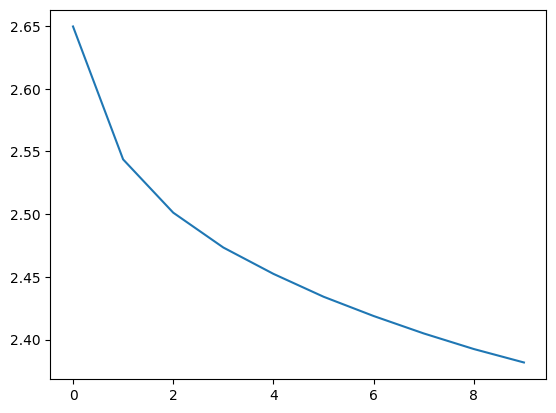

In [202]:
plt.plot(torch.tensor(losses).view(-1, len(train_dataloader)).mean(1))

### Exercises:
- Do the math and show that our gradient for the cross entropy loss is actually correct
- Split the computation of the loss into its atomic pieces and backprop through each of these pieces manually
- Train a pytorchified sub-word level MLP on tiny shakespeare
- Experiment with different optimizers, learning rates